In [23]:
data_dir = "/data/projects/dschaub/ANCA-GN_transcriptomics/data/single-cell/exploratory"
working_dir = "/data/projects/dschaub/ANCA-GN_transcriptomics"

In [24]:
%load_ext autoreload
%autoreload 2

import os
os.chdir(working_dir)

import yaml
import anndata as ad
import matplotlib.pyplot as plt
import mudata as md
import numpy as np
import scanpy as sc
from scipy import sparse
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import font_manager

from utils.utils import *
from utils.plotting import *
from utils.markers import *

sc.settings.verbosity = 0
sc.settings._vector_friendly = True

font_dirs = "/usr/share/fonts/truetype/msttcorefonts/"
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = "arial"
plt.rcParams['font.size'] = 12
# sc.set_figure_params(transparent=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [25]:
path = os.path.join(
    data_dir, "ANCA_exploratory_27PK27PB_Tcells_HarmonyR_annotated.h5mu"
)
mudata = md.read_h5mu(path)
mod_rna = mudata.mod["rna"]
mod_cite = mudata.mod["cite"]

path = os.path.join(data_dir, "ANCA_exploratory_27PK27PB_CD4Teff_annotated.h5mu")
mudata_cd4 = md.read_h5mu(path)
mod_rna_cd4 = mudata_cd4.mod["rna"]
mod_cite_cd4 = mudata_cd4.mod["cite"]

path = os.path.join(data_dir, "ANCA_exploratory_27PK27PB_CD8Teff_annotated.h5mu")
mudata_cd8 = md.read_h5mu(path)
mod_rna_cd8 = mudata_cd8.mod["rna"]
mod_cite_cd8 = mudata_cd8.mod["cite"]

In [26]:
mod_rna.obs.patient.unique()

['E016', 'E013', 'E025', 'E022', 'E014', ..., 'E007', 'E019', 'E009', 'E027', 'E015']
Length: 27
Categories (27, object): ['E016', 'E013', 'E025', 'E022', ..., 'E019', 'E009', 'E027', 'E015']

## Merge data

In [27]:
mod_rna_cd4.X = mod_rna_cd4.layers["log1p"].copy()
sc.pp.scale(mod_rna_cd4)
mod_rna_cd4.layers["scaled"] = mod_rna_cd4.X.copy()

mod_rna_cd8.X = mod_rna_cd8.layers["log1p"].copy()
sc.pp.scale(mod_rna_cd8)
mod_rna_cd8.layers["scaled"] = mod_rna_cd8.X.copy()


mod_cite_cd4.X = mod_cite_cd4.layers["clr"].copy()
sc.pp.scale(mod_cite_cd4)
mod_cite_cd4.layers["scaled"] = mod_cite_cd4.X.copy()

mod_cite_cd8.X = mod_cite_cd8.layers["clr"].copy()
sc.pp.scale(mod_cite_cd8)
mod_cite_cd8.layers["scaled"] = mod_cite_cd8.X.copy()

In [28]:
mod_rna.obs["cell_type_v1_merged"] = mod_rna.obs["cell_type_v1"].astype(str)
mod_rna.obs.loc[mod_rna_cd4.obs_names, "cell_type_v1_merged"] = mod_rna_cd4.obs[
    "cell_type_fine"
].astype(str)

mod_rna.obs.loc[mod_rna_cd8.obs_names, "cell_type_v1_merged"] = mod_rna_cd8.obs[
    "cell_type_fine"
].astype(str)

mod_rna.obs["cell_type_v1_merged"] = mod_rna.obs["cell_type_v1_merged"].astype(
    "category"
)

In [29]:
def apply_map(input_list, mapping):
    return [mapping[x] for x in input_list]

In [30]:
celltype_col = "cell_type"
celltype_col = "cell_type_v1"

celltype_map = dict(zip(mod_rna.obs["cell_type"], mod_rna.obs[celltype_col]))

## Patient mixing

In [31]:
color_map = {
    "CD4+ naive": "#1f77b4",
    "CD4+/CD8+ CM": "#ff7f0e",
    "NKT/CTL": "#279e68",
    "CD4+ EM/RM": "#d62728",
    "CD8+ EM/RM": "#aa40fc",
    "CD8+ CM/EM": "#8c564b",
    "CD4+/CD8+ stressed": "#e377c2",
    "Treg": "#b5bd61",
    "CD8+ naive": "#17becf",
    "MAIT": "#ffbb78",
    "Prolif.": "#98df8a",
    "NKT": "#aec7e8",
    "gdT": "#c5b0d5",
    "CD4+ CM": "#ff9896",
    "NK": "#c49c94",
}
color_map = {celltype_map[k]: v for k, v in color_map.items()}

order = [
    "CD4+ EM/RM",
    "CD8+ EM/RM",
    "CD4+ naive",
    "CD4+ CM",
    "CD8+ naive",
    "CD8+ CM/EM",
    "CD4+/CD8+ CM",
    "CD4+/CD8+ stressed",
    "Treg",
    "gdT",
    "MAIT",
    "NKT/CTL",
    "NKT",
    "NK",
    "Prolif.",
]
order = [celltype_map[x] for x in order]

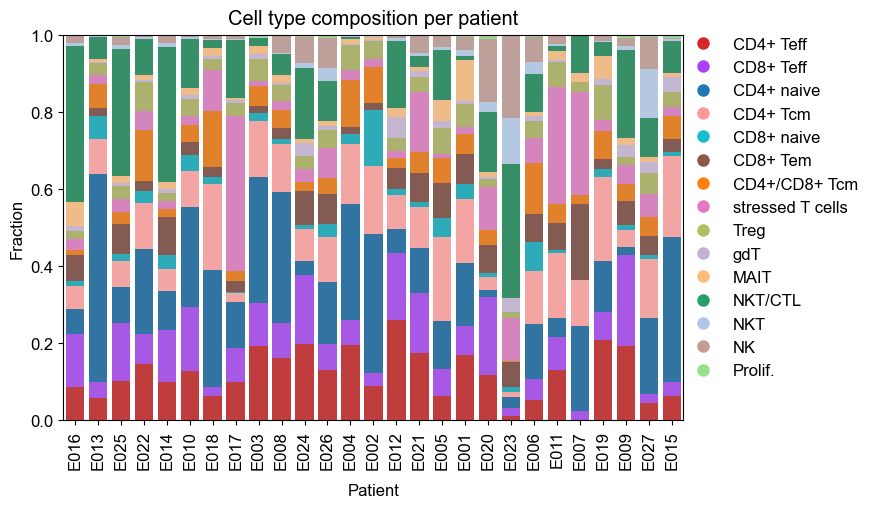

In [32]:
colors = [color_map[x] for x in order]
plot_cluster_composition_per_sample(
    mod_rna,
    colors,
    celltype_col,
    order=order,
    save_path="figures/supp/exploratory_celltype_comp_per_patient.pdf",
    title_pad=8,
)

## Quality control

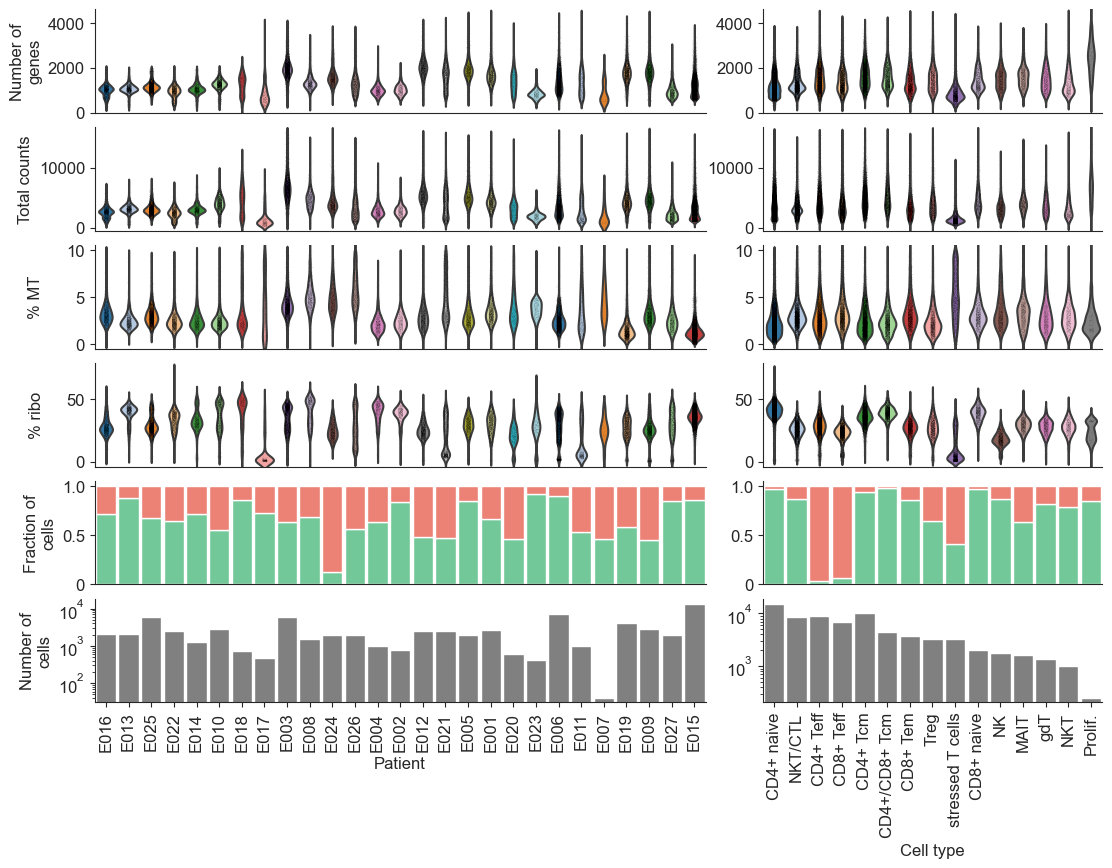

In [33]:
plot_qc(
    mod_rna,
    cell_type_key=celltype_col,
    save_path="figures/supp/exploratory_qc.pdf",
    # log_scale=False,
    hspace=0.14,
)

# Marker dotplots

In [34]:
path = os.path.join(data_dir, "..", "T_cell_markers.xlsx")
marker_df = pd.read_excel(path)
marker_df = marker_df.set_index("Cell type")

# extract positive markers
marker_db = {}
for index, row in marker_df.iterrows():
    pos_markers_1 = (
        row["positive markers 1"].replace(" ", "").split(",")
        if row["positive markers 1"] is not np.nan
        else []
    )
    pos_markers_2 = (
        row["positive markers 2"].replace(" ", "").split(",")
        if row["positive markers 2"] is not np.nan
        else []
    )
    marker_db[index] = list(set(pos_markers_1 + pos_markers_2))

marker_plotter = MarkerPlotter(mod_rna, mod_cite, marker_db, cluster_key=celltype_col)

marker_plotter = MarkerPlotter(
    mod_rna, mod_cite, marker_db, cluster_key="cell_type_v1_merged"
)

In [35]:
# marker_plotter.visualize_markers(markers=["CD3D", "CD3E"])

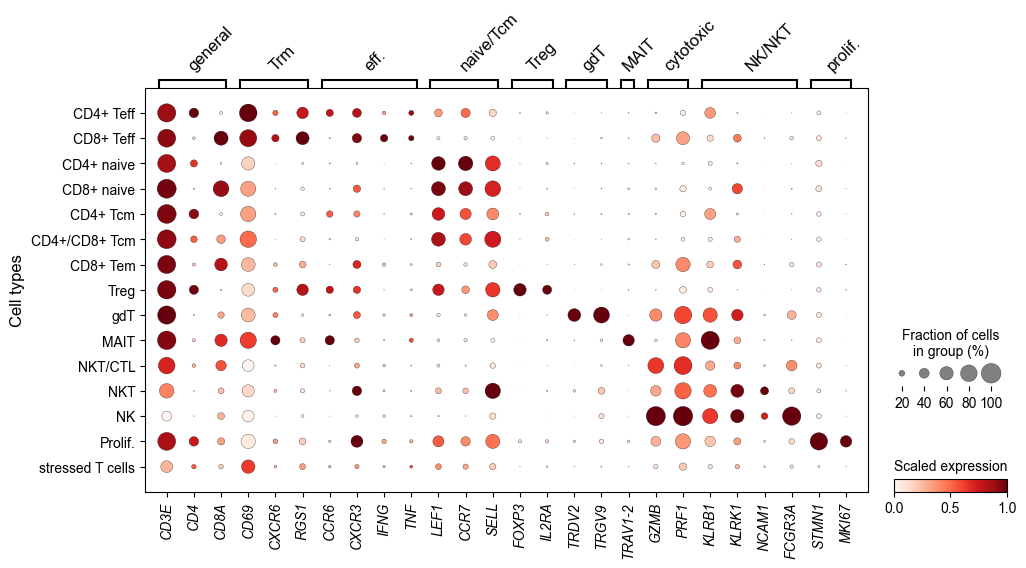

In [36]:
celltype_order = [
    "CD4+ EM/RM",
    "CD8+ EM/RM",
    "CD4+ naive",
    "CD8+ naive",
    "CD4+ CM",
    "CD4+/CD8+ CM",
    "CD8+ CM/EM",
    "Treg",
    "gdT",
    "MAIT",
    "NKT/CTL",
    "NKT",
    "NK",
    "Prolif.",
    "CD4+/CD8+ stressed",
]
celltype_order = apply_map(celltype_order, celltype_map)
dotplot_markers(
    mod_rna,
    celltype_col=celltype_col,
    celltype_order=celltype_order,
    scaled=False,
    marker_dict=get_markers_tcell(),
    # title="Broad T cell markers",
    pad=50,
    rotation=45,
    save_path="figures/supp/exploratory_tcell_markers.pdf",
)

## CD4 subset RNA

In [37]:
cmap_cd4 = {
    "Th17": "#7B1717",
    "Th1": "#A91F1F",
    "Tfh": "#E0B093",
    "Th1-like": "#D62728",
    "Tc1-like": "#D2D2D2",
}

labels_cd4 = [
    "Th17",
    "Th1",
    "Th1-like",
    "Tfh",
    "Tc1-like",
]

colors = [cmap_cd4[x] for x in labels_cd4]
orig_col = mod_rna_cd4.obs["cell_type_fine"].copy()
mod_rna_cd4.obs["cell_type_umap"] = pd.Categorical(
    mod_rna_cd4.obs["cell_type_fine"], categories=labels_cd4, ordered=True
)

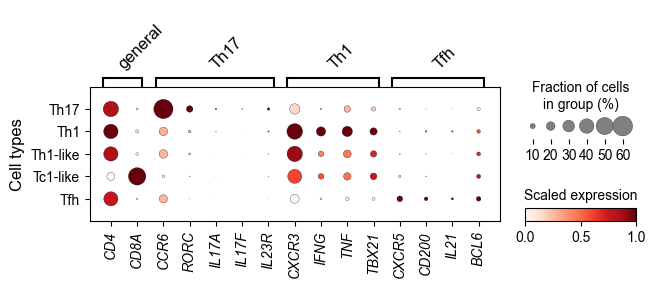

In [38]:
celltype_order = ["Th17", "Th1", "Th1-like", "Tc1-like", "Tfh"]

dotplot_markers(
    mod_rna_cd4,
    celltype_col="cell_type_fine",
    celltype_order=celltype_order,
    marker_dict=get_markers_cd4(),
    # title="CD4+ Teff markers",
    pad=25,
    scaled=False,
    figsize=(7, 3),
    # vmax=0.3,
    rotation=45,
    save_path="figures/supp/exploratory_cd4_markers.pdf",
)

## CD8 subset RNA

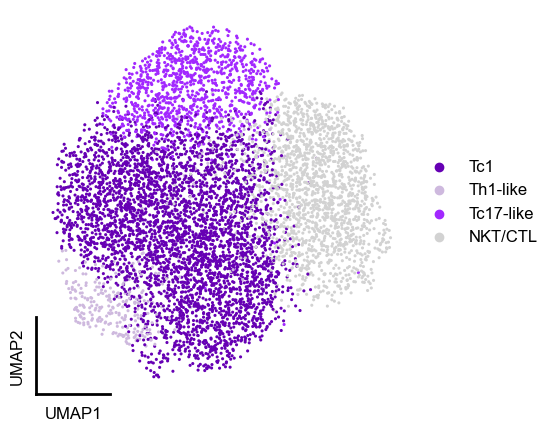

In [39]:
celltype_col_cd8 = "cell_type_fine_v1"
# celltype_col_cd8 = "cell_type_fine"

# cmap_cd8 = {
#     "Tc1": "#6600B4",
#     "Tc1-like": "#840AE2",
#     "Tc17-like": "#A228FF",
#     "Th1-like": "#CEB9DE",
#     "NKT/CTL": "#D2D2D2",
# }

# labels_cd8 = [
#     "Tc1",
#     "Tc1-like",
#     "Tc17-like",
#     "Th1-like",
#     "NKT/CTL",
# ]


cmap_cd8 = {
    "Tc1": "#6600B4",
    # "Tc1-like": "#840AE2",
    "Tc17-like": "#A228FF",
    "Th1-like": "#CEB9DE",
    "NKT/CTL": "#D2D2D2",
}

labels_cd8 = [
    "Tc1",
    "Th1-like",
    # "Tc1-like",
    "Tc17-like",
    "NKT/CTL",
]
colors = [cmap_cd8[x] for x in labels_cd8]
orig_col = mod_rna_cd8.obs[celltype_col_cd8].copy()
mod_rna_cd8.obs["cell_type_umap"] = pd.Categorical(
    mod_rna_cd8.obs[celltype_col_cd8], categories=labels_cd8, ordered=True
)
plot_umap(
    mod_rna_cd8,
    color="cell_type_umap",
    palette=colors,
    figsize=(5.5, 5),
    title="",
    size=20,
    # save_path="figures/main/exploratory_umap.pdf",
)

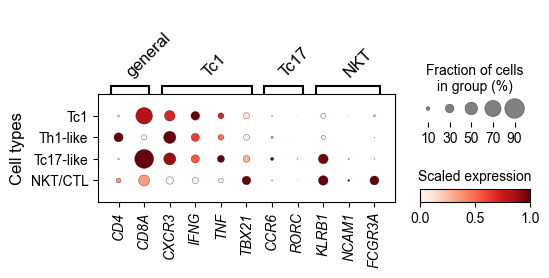

: 

In [40]:
from collections import OrderedDict

celltype_col_cd8 = "cell_type_fine_v1"

celltype_order = ["Tc1", "Tc1-like", "Th1-like", "Tc17-like", "NKT/CTL"]
celltype_order = ["Tc1", "Th1-like", "Tc17-like", "NKT/CTL"]

markers = get_markers_cd8(mod_rna_cd8)
del markers["naive/Tcm"]

fig = dotplot_markers(
    mod_rna_cd8,
    celltype_col=celltype_col_cd8,
    celltype_order=celltype_order,
    marker_dict=markers,
    scaled=False,
    figsize=(5.0, 2.6),
    mod="rna",
    # title="CD8+ Teff markers",
    pad=25,
    rotation=45,
    # vmax=0.3,
    save_path="figures/supp/exploratory_cd8_markers.pdf",
    return_fig=True,
)
gene_ax = fig["gene_group_ax"]

## Gene scores

In [41]:
th1_genes = [
    "IFNG",
    "IL2",
    "TNF",
    "LTA",
    "CSF2",
    "IL18",
]
th2_genes = [
    "IL4",
    "IL5",
    "IL9",
    "IL13",
    # "IL10",
    # "IL21",
    # "IL6",
]
th17_genes = ["IL17A", "IL17F", "IL22", "IL26"]

gene_list = th1_genes + th2_genes + th17_genes

mod_rna.X = mod_rna.layers["scaled"].copy()

cytokine_markers = gene_list
sc.tl.score_genes(
    mod_rna,
    gene_list=cytokine_markers,
    score_name="cytokine_score",
    ctrl_size=50,
    use_raw=False,
)
sc.tl.score_genes(
    mod_rna,
    gene_list=th1_genes,
    score_name="type1_score",
    ctrl_size=50,
    use_raw=False,
)
sc.tl.score_genes(
    mod_rna,
    gene_list=th2_genes,
    score_name="type2_score",
    ctrl_size=50,
    use_raw=False,
)
sc.tl.score_genes(
    mod_rna,
    gene_list=th17_genes,
    score_name="type3_score",
    ctrl_size=50,
    use_raw=False,
)
mod_rna.X = mod_rna.layers["log1p"].copy()

In [ ]:
scores = mod_rna.obs[["type1_score", "type2_score", "type3_score"]].copy()

In [ ]:
mod_rna.obs[["type1_score", "type2_score", "type3_score"]] = scores.copy()

In [ ]:
groupby = "cell_type_agg"
groupby = celltype_col

if groupby == "cell_type_agg":
    order = ["CD4+ Teff", "CD8+ Teff", "NKT/CTL", "CD4+ Tcm", "CD4+ naive", "others"]

    mod_rna.obs[groupby] = pd.Categorical(
        mod_rna.obs[groupby], categories=order, ordered=True
    )
else:
    order = [
        "CD4+ EM/RM",
        "CD8+ EM/RM",
        "CD4+ naive",
        "CD4+ CM",
        "CD8+ naive",
        "CD8+ CM/EM",
        "CD4+/CD8+ CM",
        "CD4+/CD8+ stressed",
        "Treg",
        "gdT",
        "MAIT",
        "NKT/CTL",
        "NKT",
        "NK",
        "Prolif.",
    ]
    order = [celltype_map[x] for x in order]
    mod_rna.obs[celltype_col] = pd.Categorical(
        mod_rna.obs[celltype_col], categories=order, ordered=True
    )
swap_axes = True
swap_axes = False
fig = sc.pl.dotplot(
    mod_rna,
    var_names=["type1_score", "type2_score", "type3_score"],
    # groupby="cell_type_agg",
    groupby=groupby,
    color_map="RdBu_r",
    vmin=-0.14,
    vmax=0.14,
    # return_fig=True,
    show=False,
    # title="",
    # size_title=0,
    figsize=(7, 1.5) if swap_axes else None,
    colorbar_title="zscore per group",
    swap_axes=swap_axes,
)
ax = fig["mainplot_ax"]
if swap_axes:
    ax.set_yticklabels(["Type 1", "Type 2", "Type 3"], rotation=0)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
else:
    ax.set_xticklabels(["Type 1", "Type 2", "Type 3"], rotation=90, ha="center")
plt.savefig(
    "figures/supp/exploratory_cytokine_score_dotplot.pdf",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)
plt.show()